### Goal : Decompose time-series data into three terms: trend, period & random


Resources/Bibliograpy:
- [Basic Fourier transform](http://www.phys.nsu.ru/cherk/fft.pdf)
- [Fourier Decomposition Analysis for non-linear & non-stationary data](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0871)
- [Empirical Mode Decomposition (EMD)]()
- [Ensemble Empirical Mode Decomposition (EEMD)](https://www.worldscientific.com/doi/abs/10.1142/S1793536909000047)
- [EEMD + LSTM](https://link.springer.com/article/10.1007/s11269-019-02345-1)

In [5]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load data 
csv_index   = 31
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_basic    = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
synth_name  = "soil"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_soil     = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)

time for importing dataframe: 0.71 seconds
time for importing dataframe: 0.78 seconds


In [10]:
# Preprocess data
df_basic = downsample_dataframe(df_basic, night_method='basic', clip_method='universal')
df_soil  = downsample_dataframe(df_soil, night_method='basic', clip_method='universal')

(244249, 8)
(168166, 8)


In [11]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [12]:
df_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [13]:
df_basic.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,371.108434,167.144578,7.353815,0.0,0.999991,1.0,1.0,759.108434
2015-01-02 00:00:00-05:00,376.153226,169.137097,7.321774,0.0,0.999980,1.0,1.0,760.262097
2015-01-03 00:00:00-05:00,378.401606,169.971888,7.284739,0.0,0.999965,1.0,1.0,761.309237
2015-01-04 00:00:00-05:00,380.956000,170.872000,7.244400,0.0,0.999950,1.0,1.0,762.352000
2015-01-05 00:00:00-05:00,383.800797,171.888446,7.210757,0.0,0.999935,1.0,1.0,763.390438


In [14]:
df_soil.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,376.396825,169.214286,7.361111,0.0,0.999985,0.998957,1.0,759.420635
2015-01-02 00:00:00-05:00,381.123506,171.207171,7.328287,0.0,0.999955,0.998275,1.0,760.561753
2015-01-03 00:00:00-05:00,383.162698,172.051587,7.291667,0.0,0.999925,0.997591,1.0,761.595238
2015-01-04 00:00:00-05:00,385.474308,172.956522,7.251383,0.0,0.999894,0.996908,1.0,762.624506
2015-01-05 00:00:00-05:00,387.984252,173.980315,7.217323,0.0,0.999862,0.996225,1.0,763.649606


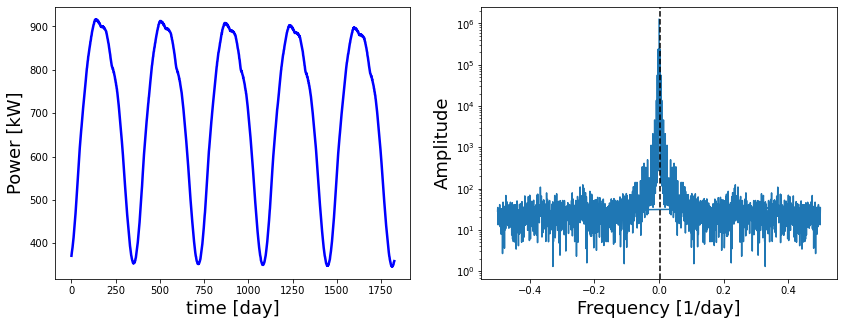

In [18]:
# Manually obtain the frequencies (similar to fftpack.fftfreq)
#L = len(df["Power"].to_numpy()) # length of signal
#T = 1 # [day] # sampling period
#Fs = 1/T # [1/day] # sampling frequency
#freq = Fs*np.arange(L/2)/L
# =========================================================================

power_fft = fftpack.fft(df_basic["Power"].to_numpy())
sample_freq = fftpack.fftfreq(df_basic["Power"].to_numpy().size, d=1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)

ax[1].plot(sample_freq, np.abs(power_fft)) # plot freq domain
ax[1].axvline(1/365, ls="--", color="k") # this is the year frequency

ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Frequency [1/day]", fontsize=18)
#ax[1].set_xlim([0, 0.1])
#ax[1].set_xscale("log")
ax[1].set_yscale("log")

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

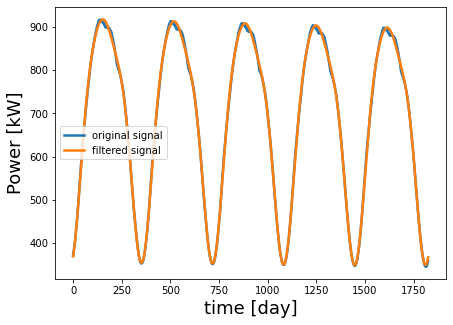

In [20]:
# remove all the hight frequencies
high_freq_fft = power_fft.copy()
high_freq_fft[np.abs(sample_freq) > 0.01] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5)
ax.plot(filtered_sig, label="filtered signal", lw=2.5)
ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

### Plot FT for basic and soiling for (a) daily frequency

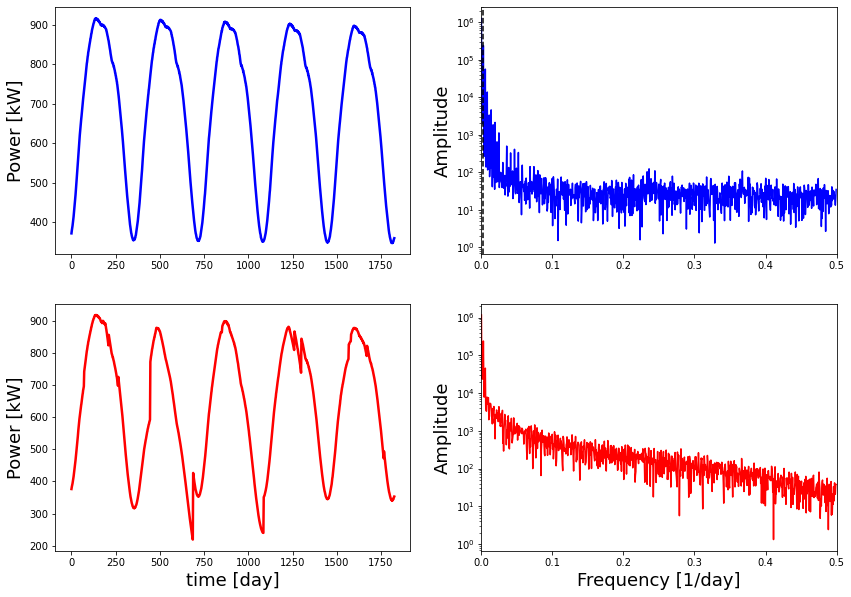

In [21]:
size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[0, 1].axvline(1/365, ls="--", color="k") # this is the year frequency
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain

ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.5])
ax[1, 1].set_xlim([0, 0.5])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

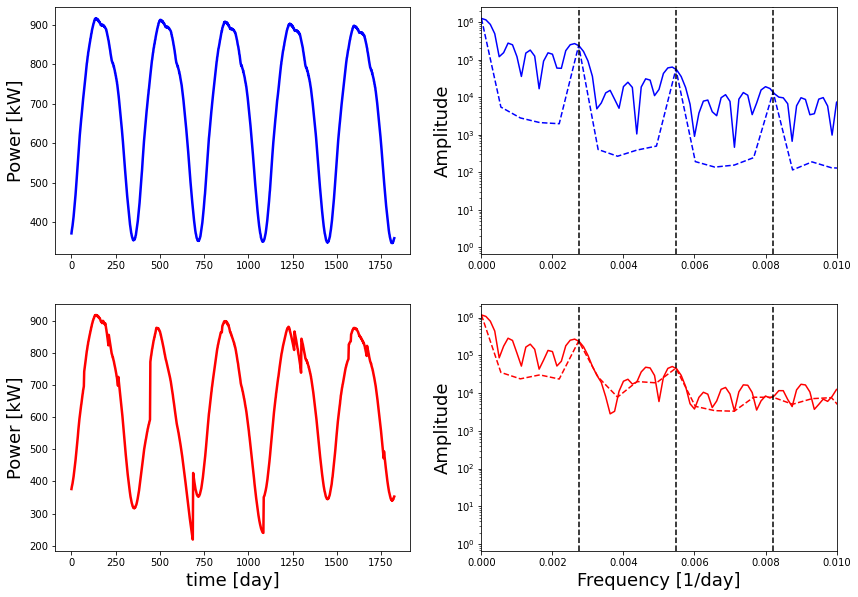

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 8000#df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

for i in range(3):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency


ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.01])
ax[1, 1].set_xlim([0, 0.01])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

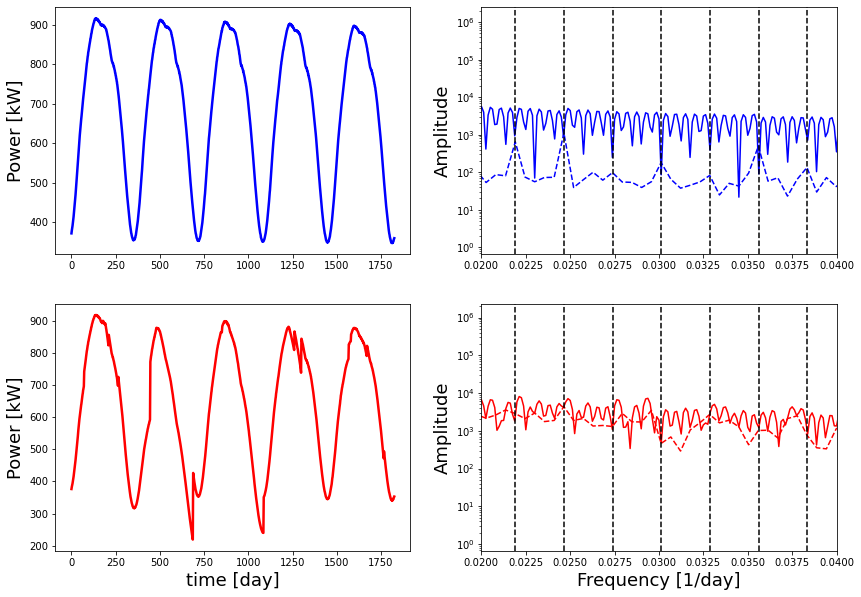

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 8000#df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

for i in range(15):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.02, 0.04])
ax[1, 1].set_xlim([0.02, 0.04])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

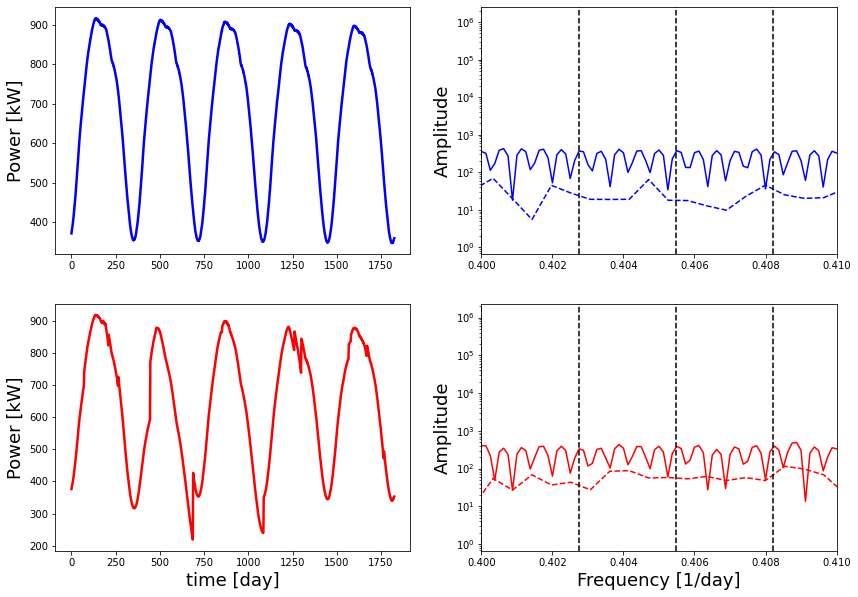

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

size              = 8000#df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")    # plot time series
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")    # plot time series
ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue") # plot freq domain
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red") # plot freq domain


size              = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(size, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(size/2)], np.abs(power_basic[0:int(size/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(size/2)], np.abs(power_soil[0:int(size/2)]), color="red", ls="--")

for i in range(150):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.4, 0.41])
ax[1, 1].set_xlim([0.4, 0.41])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

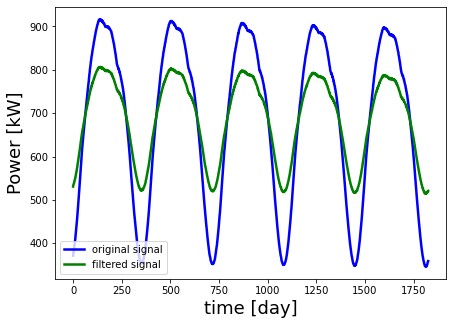

In [124]:
## Filter out frequency 1/365 and all the corresponding harmonics
fig, ax = plt.subplots(figsize=(7, 5))

high_freq_basic = power_basic.copy()
for i in range(120):
    #print (np.where(np.abs(sample_freq_basic-(i+1)/365) < 1e-5))
    #pos = np.where(np.abs(sample_freq_basic-(i+1)/365) < 1e-5)
    high_freq_basic[5*(i+1)] = 0.
    #ax.plot(fftpack.ifft(high_freq_basic), lw=2.5)

filtered_sig = fftpack.ifft(high_freq_basic)

ax.plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax.plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")

ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

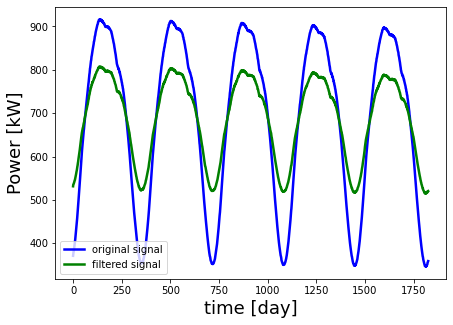

In [98]:
## Filter out frequency 1/365 and all the corresponding harmonics
fig, ax = plt.subplots(figsize=(7, 5))

high_freq_basic = power_basic.copy()
for i in range(6):
    #print (np.where(np.abs(sample_freq_basic-(i+1)/365) < 1e-5))
    pos = np.where(np.abs(sample_freq_basic-(i+1)/365) < 1e-5)
    high_freq_basic[pos] = 0.
    #ax.plot(fftpack.ifft(high_freq_basic), lw=2.5)

filtered_sig = fftpack.ifft(high_freq_basic)

ax.plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax.plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")

ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

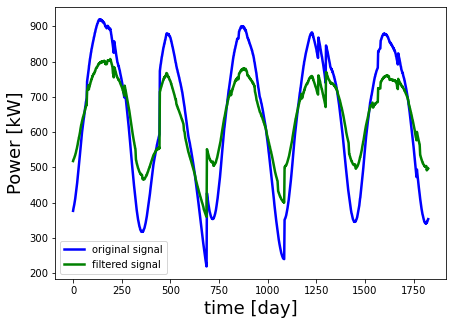

In [125]:
## Filter out frequency 1/365 and all the corresponding harmonics
fig, ax = plt.subplots(figsize=(7, 5))

high_freq_soil = power_soil.copy()
for i in range(120):
    #pos = np.where(np.abs(sample_freq_soil-(i+1)/365) < 1e-5)
    high_freq_soil[5*(i+1)] = 0.
    #ax.plot(fftpack.ifft(high_freq_soil), lw=2.5)

filtered_sig = fftpack.ifft(high_freq_soil)

ax.plot(df_soil["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax.plot(fftpack.ifft(high_freq_soil), label="filtered signal", lw=2.5, color="green")

ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

### Plot FT for basic and soiling for (a) hourly frequency